In [145]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path
import os

train_sentences = np.load('./data/FS_train.npy', allow_pickle=True)
train_labels = np.load('./data/FS_labels.npy', allow_pickle=True)
test_sentences = np.load('./data/FS_test.npy', allow_pickle=True)

# Convert the numpy arrays to pandas DataFrames
df_train = pd.DataFrame({
    'Sentences': train_sentences,
    'Labels': train_labels
})

df_test = pd.DataFrame({
    'Sentences': test_sentences
})

print(df_train.head())
print(df_test.head())

                                           Sentences  Labels
0  6 : 28 If there be dearth in the land, if ther...       0
1  8 : 23 And I will put a division between my to...       1
2  Pausing, he waited for her to turn, to ask a q...       0
3    I warrant you she is a fine size by this time."       0
4  The East was popularly supposed to have got th...       0
                                           Sentences
0  The bars were marked as Walter had marked them...
1  Last came a little feeble, squeaking voice, ('...
2  And in all probability you will see your broth...
3  8 : 50 And I seek not mine own glory : there i...
4  20 : 11 But the LORD is with me as a mighty te...


In [146]:
df_train.Labels.value_counts()

Labels
1    90008
0    89992
Name: count, dtype: int64

In [147]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index
embeddings_index = get_embeddings('./crawl-300d-2M.vec')

In [148]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split(' '))

from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

df_train['Sentences'] = df_train.Sentences.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(df_train.Sentences)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')


df_test['Sentences'] = df_test.Sentences.apply(preprocess)

Creating the vocabulary of words occurred more than 5
27005 top words


In [152]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['computer', 'jealousy', 'herman', 'graceful', 'inn', 'counseling', 'balancing', 'blink', 'tussle', 'surmised']

Is "unknown" in top_words? 
 True


In [153]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

df_train['Sentences'] = df_train.Sentences.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))


df_test['Sentences'] = df_test.Sentences.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

In [154]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(df_train.Sentences)
print(tokenizer)

In [155]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

25195


[('unknown', 1),
 ('the', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ('a', 6),
 ('in', 7),
 ('that', 8),
 ('he', 9),
 ('i', 10),
 ('it', 11),
 ('for', 12),
 ('his', 13),
 ('was', 14),
 ('is', 15),
 ('with', 16)]

In [143]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(df_train.Sentences)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open('./fake_sentence.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[1, 1, 1, 1, 1, 1, 1, 57, 50, 17, 10984, 7, 2, 161, 1, 57, 50, 17, 4011, 1, 57, 50, 17, 11749, 1, 41, 16393, 1, 8912, 1, 41, 19723, 1, 1, 57, 42, 747, 11750, 35, 7, 2, 456, 4, 42, 161, 1, 1, 1807, 1886, 41, 1807, 5296, 50, 17, 1, 1, 1, 1, 1, 1, 1, 1, 1, 63, 59, 1501, 41, 59, 5060, 9595, 36, 17, 98, 4, 79, 60, 1, 41, 4, 23, 71, 105, 142, 1, 51, 112, 47, 36, 103, 13, 128, 1886, 3, 13, 128, 3242, 1, 3, 36, 821, 246, 13, 248, 7, 32, 108, 1, 1, 1, 1, 1, 1, 1, 1, 1, 63, 236, 62, 33, 257, 71, 2942, 169, 1, 3, 2038, 1, 3, 3687, 49, 112, 60, 305, 49, 23, 13, 620, 1, 291, 203, 62, 2326, 1, 1, 1, 1, 12, 62, 86, 2326, 2, 1263, 4, 2, 140, 4, 109, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 24, 94, 377, 75, 1, 5, 489, 7, 71, 620, 1, 46, 143, 18, 24, 405, 7, 2, 161, 34, 62, 6079, 49, 90, 484, 1], [1, 1, 1, 1, 1, 1, 1, 3, 10, 48, 175, 6, 2327, 217, 37, 5, 319, 1, 1, 3, 38, 961, 25, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1]]

Shape of `data`:  (180000, 50)

First prepared text in `data`: [    1

In [144]:
MAX_SEQUENCE_LENGTH = 50
seq_test = tokenizer.texts_to_sequences(df_test.Sentences)
data_test = pad_sequences(seq_test,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open('./fake_sentence_test.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq_test[:2])
print('\nShape of `data`: ',data_test.shape)
print('\nFirst prepared text in `data`:',data_test[0])


First 2 sequences in `seq`:  [[2, 2588, 44, 1912, 18, 1502, 26, 1912, 35, 7, 6, 275, 434, 507, 483, 7, 6, 1018, 792, 1], [179, 95, 6, 99, 1, 15368, 1, 1, 8, 20, 45, 1, 194, 1, 20, 1, 10, 673, 103, 1, 56, 1, 1391, 80, 1, 10, 20, 397, 252, 68, 1, 22, 10, 16, 2, 1, 154, 237, 1]]

Shape of `data`:  (20000, 50)

First prepared text in `data`: [   2 2588   44 1912   18 1502   26 1912   35    7    6  275  434  507
  483    7    6 1018  792    1    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [156]:
# Create embedding matrix

embeddings_dim = len(next(iter(embeddings_index.values())))
print(embeddings_dim)

def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

300


In [157]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = './fake_sentence_embed_layer.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

0 unknown words


In [132]:
from tensorflow.keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from tensorflow.keras.layers import SpatialDropout1D, Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard,  ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Embedding, SpatialDropout1D, LSTM, Conv1D, Flatten, BatchNormalization, Dropout, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, Bidirectional
from keras.models import Model
from keras.optimizers import Adam

def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    # Stack multiple LSTM layers
    x = LSTM(50, return_sequences=True)(x)
    x = LSTM(50, return_sequences=True)(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    x = BatchNormalization()(conc)
    x = Dropout(0.5)(x)  # Increased dropout rate
    # Multiple dense layers
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation="relu")(x)
    output_layer = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer='RMSprop')  # Changed optimizer
    return model


In [133]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: embedding_layer = pickle.load(f)
with open('./fake_sentence.pkl', 'rb') as f: data = pickle.load(f)   

X_train, X_test, y_train, y_test = train_test_split(data, df_train.Labels, 
                    test_size=0.2, stratify = df_train.Labels, random_state=0)

best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_model()
print(model.summary())
plot_model(model, to_file='wine_reviews.png',show_shapes=True,show_layer_names=True)

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 50, 300)      7558800     ['input_20[0][0]']               
                                                                                                  
 spatial_dropout1d_19 (SpatialD  (None, 50, 300)     0           ['embedding_4[0][0]']            
 ropout1D)                                                                                        
                                                                                                  
 lstm_19 (LSTM)                 (None, 50, 50)       70200       ['spatial_dropout1d_19[0][

2023-10-21 21:55:29.741047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-21 21:55:29.741815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-21 21:55:29.742579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [134]:
hist = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                 epochs=100, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[early_stopping])
# model.load_weights(best_model_path)
test_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_test, test_pred))

Epoch 1/100


2023-10-21 21:55:38.273881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-21 21:55:38.274748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-21 21:55:38.275450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

282/282 - 6s - loss: 0.6923 - val_loss: 0.6991 - 6s/epoch - 20ms/step
Epoch 2/100
282/282 - 3s - loss: 0.6690 - val_loss: 0.6849 - 3s/epoch - 11ms/step
Epoch 3/100
282/282 - 3s - loss: 0.6478 - val_loss: 0.6332 - 3s/epoch - 11ms/step
Epoch 4/100
282/282 - 3s - loss: 0.6342 - val_loss: 0.6063 - 3s/epoch - 11ms/step
Epoch 5/100
282/282 - 3s - loss: 0.6224 - val_loss: 0.6095 - 3s/epoch - 11ms/step
Epoch 6/100
282/282 - 3s - loss: 0.6107 - val_loss: 0.5983 - 3s/epoch - 11ms/step
Epoch 7/100
282/282 - 3s - loss: 0.6041 - val_loss: 0.5948 - 3s/epoch - 11ms/step
Epoch 8/100
282/282 - 3s - loss: 0.5967 - val_loss: 0.5887 - 3s/epoch - 11ms/step
Epoch 9/100
282/282 - 3s - loss: 0.5914 - val_loss: 0.5716 - 3s/epoch - 11ms/step
Epoch 10/100
282/282 - 3s - loss: 0.5876 - val_loss: 0.5681 - 3s/epoch - 11ms/step
Epoch 11/100
282/282 - 3s - loss: 0.5822 - val_loss: 0.5605 - 3s/epoch - 11ms/step
Epoch 12/100
282/282 - 3s - loss: 0.5785 - val_loss: 0.5754 - 3s/epoch - 11ms/step
Epoch 13/100
282/282 - 3s

2023-10-21 21:56:32.258119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-21 21:56:32.258910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-21 21:56:32.259395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

validation AUC 0.7918459650227896


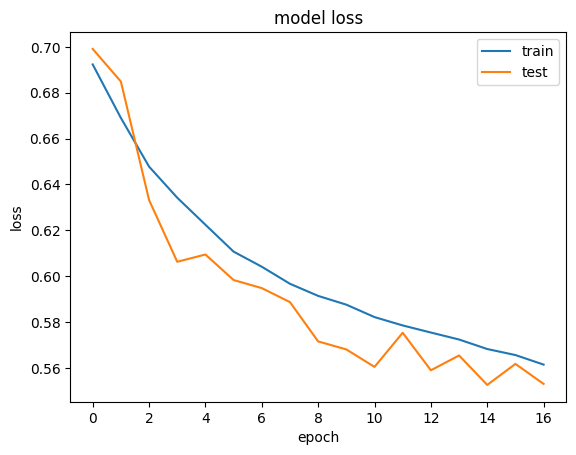

In [137]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [138]:
# hist2 = model.fit(data, df_train.Labels,
#                  epochs=25, batch_size=BATCH_SIZE, shuffle=True, verbose=2)


test_pred = model.predict(data_test, batch_size=BATCH_SIZE, verbose=0)
arr = np.where(test_pred > 0.5, 1, 0)
np.savetxt('submission.csv', arr, fmt='%d', delimiter=',')